In [13]:
# =============================================================================
# THECB ENROLLMENT DATA ANALYSIS - FIXED
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load THECB enrollment data
print("Loading THECB enrollment data...")
thecb_data = pd.read_csv('Datathon_Data/THECB_combined.csv')

print(f"Original shape: {thecb_data.shape}")

# =============================================================================
# CLEAN DATA
# =============================================================================

print("\n" + "="*70)
print("CLEANING DATA")
print("="*70)

# 1. Remove non-college categories
exclude_categories = ['Not found ', 'Total high school graduates ', 'Not trackable ']
print(f"Before removing non-college: {len(thecb_data)}")
thecb_data = thecb_data[~thecb_data['Institution'].isin(exclude_categories)]
print(f"After removing non-college: {len(thecb_data)}")

# 2. Standardize county names (remove " COUNTY" suffix)
thecb_data['County'] = thecb_data['County'].str.replace(' COUNTY', '', regex=False)
thecb_data['County'] = thecb_data['County'].str.replace(' COUNT', '', regex=False)
thecb_data['County'] = thecb_data['County'].str.replace(' COUN', '', regex=False)
thecb_data['County'] = thecb_data['County'].str.strip()

print(f"\nUnique counties after standardization: {thecb_data['County'].nunique()}")
print(f"\nTop 20 institutions:")
print(thecb_data['Institution'].value_counts().head(20))

# =============================================================================
# FILTER FOR TXST AND COMPETITORS
# =============================================================================

print("\n" + "="*70)
print("FILTERING FOR TXST AND COMPETITORS")
print("="*70)

# Filter for key schools
txst_data = thecb_data[thecb_data['Institution'].str.contains('TEXAS STATE UNIVERSITY', case=False, na=False)]
ut_data = thecb_data[thecb_data['Institution'].str.contains('U. OF TEXAS AT AUSTIN', case=False, na=False)]
tamu_data = thecb_data[thecb_data['Institution'].str.contains('TEXAS A&M UNIVERSITY \(003632\)', case=False, na=False)]
tech_data = thecb_data[thecb_data['Institution'].str.contains('TEXAS TECH UNIVERSITY', case=False, na=False)]
sfa_data = thecb_data[thecb_data['Institution'].str.contains('STEPHEN F. AUSTIN STATE UNIV', case=False, na=False)]
utsa_data = thecb_data[thecb_data['Institution'].str.contains('U. OF TEXAS AT SAN ANTONIO', case=False, na=False)]
unt_data = thecb_data[thecb_data['Institution'].str.contains('UNIVERSITY OF NORTH TEXAS', case=False, na=False)]
uh_data = thecb_data[thecb_data['Institution'].str.contains('UNIVERSITY OF HOUSTON \(003652\)', case=False, na=False)]

print(f"TXST records: {len(txst_data)}")
print(f"UT Austin records: {len(ut_data)}")
print(f"Texas A&M records: {len(tamu_data)}")
print(f"Texas Tech records: {len(tech_data)}")
print(f"Stephen F. Austin records: {len(sfa_data)}")
print(f"UT San Antonio records: {len(utsa_data)}")
print(f"UNT records: {len(unt_data)}")
print(f"UH records: {len(uh_data)}")

# =============================================================================
# AGGREGATE BY COUNTY (combining duplicates)
# =============================================================================

print("\n" + "="*70)
print("COUNTY-LEVEL ENROLLMENT (Standardized)")
print("="*70)

county_enrollment = thecb_data.groupby('County')['Students'].sum().reset_index()
county_enrollment.columns = ['County', 'Total_Enrollment']
county_enrollment = county_enrollment.sort_values('Total_Enrollment', ascending=False)

print("Top 20 counties by total enrollment:")
print(county_enrollment.head(20))

# =============================================================================
# TXST MARKET SHARE BY COUNTY
# =============================================================================

txst_by_county = txst_data.groupby('County')['Students'].sum().reset_index()
txst_by_county.columns = ['County', 'TXST_Enrollment']

market_share = txst_by_county.merge(county_enrollment, on='County')
market_share['TXST_Market_Share'] = (market_share['TXST_Enrollment'] / 
                                      market_share['Total_Enrollment'] * 100)
market_share = market_share.sort_values('TXST_Market_Share', ascending=False)

print("\n" + "="*70)
print("TXST MARKET SHARE (Top 20)")
print("="*70)
print(market_share.head(20))

# =============================================================================
# COMPETITIVE COMPARISON
# =============================================================================

competitors = {
    'TXST': txst_data,
    'UT Austin': ut_data,
    'Texas A&M': tamu_data,
    'Texas Tech': tech_data,
    'Stephen F. Austin': sfa_data,
    'UTSA': utsa_data,
    'UNT': unt_data,
    'UH': uh_data
}

comparison_data = []
for school_name, school_data in competitors.items():
    county_counts = school_data.groupby('County')['Students'].sum().reset_index()
    county_counts.columns = ['County', school_name]
    comparison_data.append(county_counts)

comparison_df = comparison_data[0]
for df in comparison_data[1:]:
    comparison_df = comparison_df.merge(df, on='County', how='outer')

comparison_df = comparison_df.fillna(0)

competitor_cols = ['TXST', 'UT Austin', 'Texas A&M', 'Texas Tech', 
                   'Stephen F. Austin', 'UTSA', 'UNT', 'UH']
comparison_df['Total'] = comparison_df[competitor_cols].sum(axis=1)
comparison_df['TXST_Share'] = (comparison_df['TXST'] / comparison_df['Total'] * 100).fillna(0)

print("\n" + "="*70)
print("COUNTIES WHERE COMPETITORS DOMINATE (TXST <10%)")
print("="*70)
low_share = comparison_df[
    (comparison_df['TXST_Share'] < 10) & 
    (comparison_df['Total'] > 0)
].sort_values('Total', ascending=False)
print(low_share.head(20))

# Export
comparison_df.to_csv('county_competitive_comparison.csv', index=False)
market_share.to_csv('txst_market_share_by_county.csv', index=False)

# =============================================================================
# OPPORTUNITY ANALYSIS
# =============================================================================

opportunities = comparison_df[
    (comparison_df['Total'] > 100) &
    (comparison_df['TXST_Share'] < 15)
].copy()

opportunities['Opportunity_Score'] = opportunities['Total'] * (100 - opportunities['TXST_Share'])
opportunities = opportunities.sort_values('Opportunity_Score', ascending=False)

print("\n" + "="*70)
print("TOP OPPORTUNITY COUNTIES")
print("="*70)
print(opportunities[['County', 'Total', 'TXST', 'TXST_Share', 'Opportunity_Score']].head(20))

opportunities.to_csv('recruitment_opportunities.csv', index=False)

print("\n" + "="*70)
print("FILES SAVED - DATA NOW CLEAN!")
print("="*70)

Loading THECB enrollment data...
Original shape: (50207, 6)

CLEANING DATA
Before removing non-college: 50207
After removing non-college: 36175

Unique counties after standardization: 265

Top 20 institutions:
Institution
TEXAS A&M UNIVERSITY (003632)              1636
TEXAS STATE UNIVERSITY (003615)            1273
TEXAS TECH UNIVERSITY (003644)             1174
U. OF TEXAS AT AUSTIN (003658)             1106
BLINN COLLEGE DISTRICT (003549)            1022
UNIVERSITY OF NORTH TEXAS (003594)          858
U. OF TEXAS AT SAN ANTONIO (010115)         848
TARLETON STATE UNIVERSITY (003631)          715
SAM HOUSTON STATE UNIVERSITY (003606)       662
STEPHEN F. AUSTIN STATE UNIV (003624)       609
U. OF TEXAS AT ARLINGTON (003656)           547
Other Pub/Ind 2-yr Institution (2)          536
UNIVERSITY OF HOUSTON (003652)              524
Other Pub/Ind 2-yr Institution (3)          510
TYLER JUNIOR COLLEGE (003648)               486
TEXAS A&M UNIV-CORPUS CHRISTI (011161)      476
Other Pub/

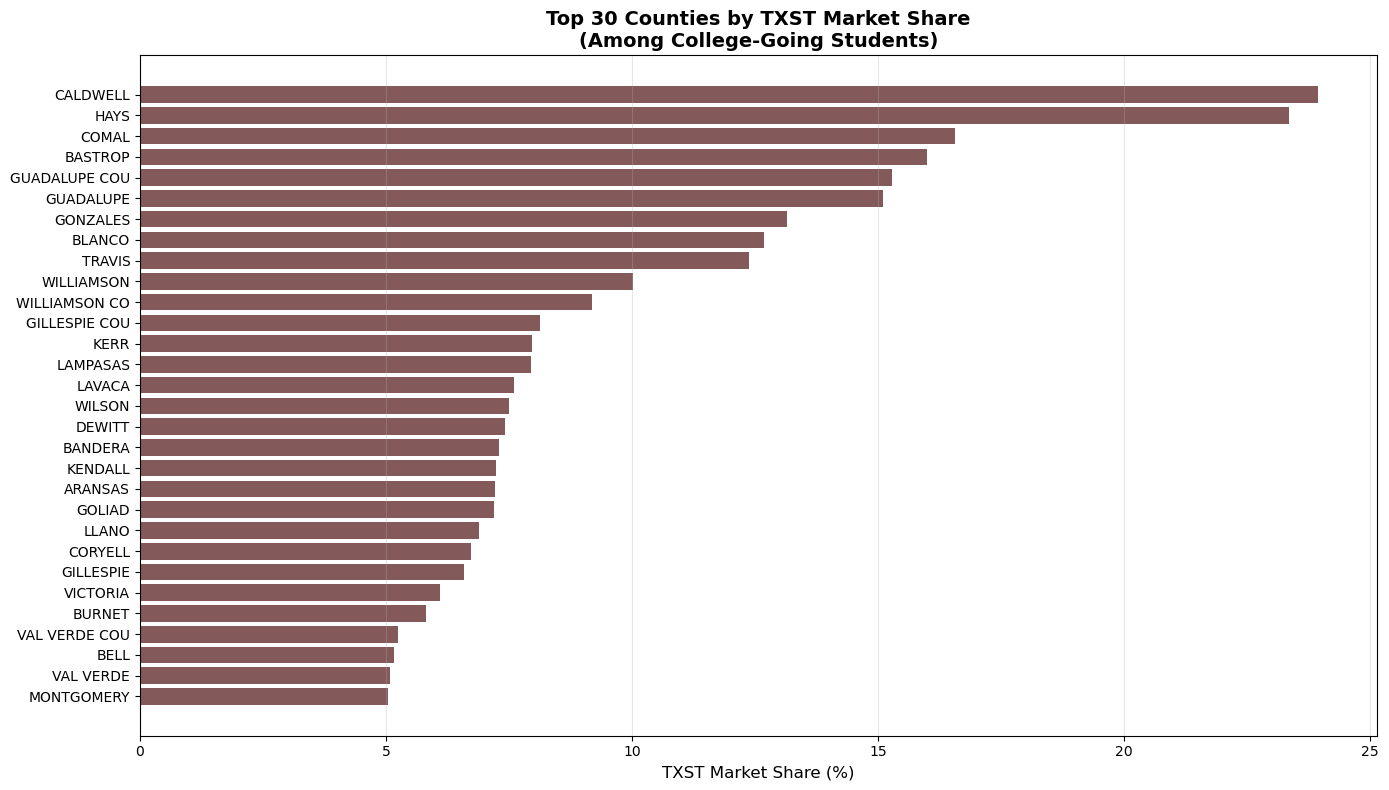

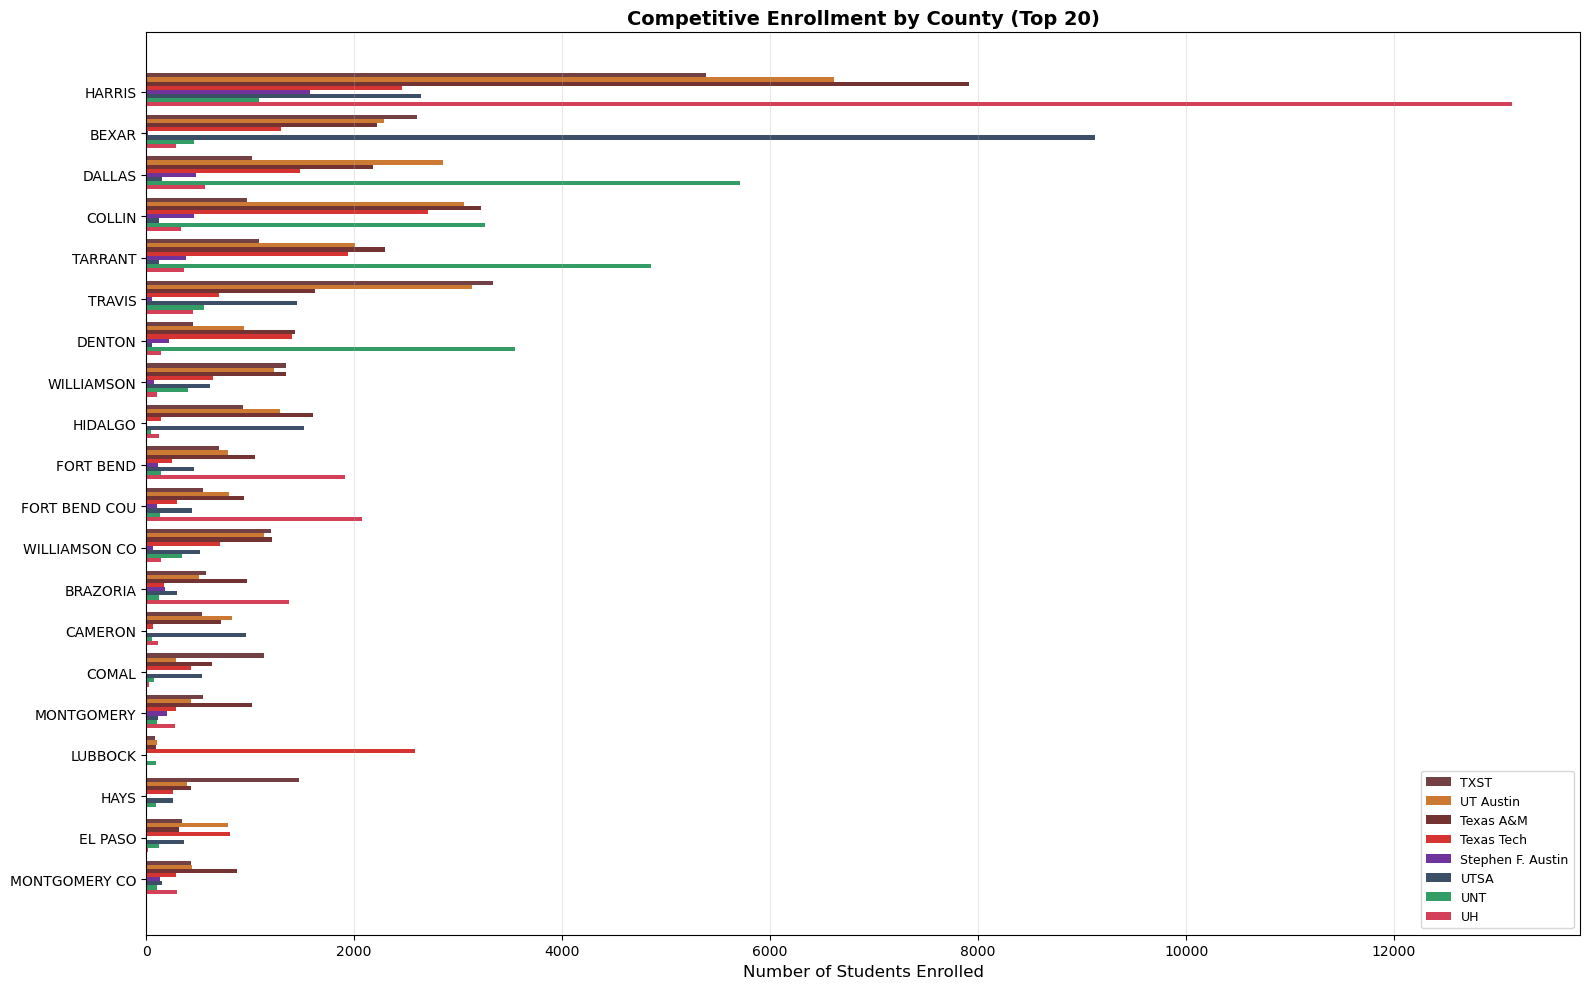

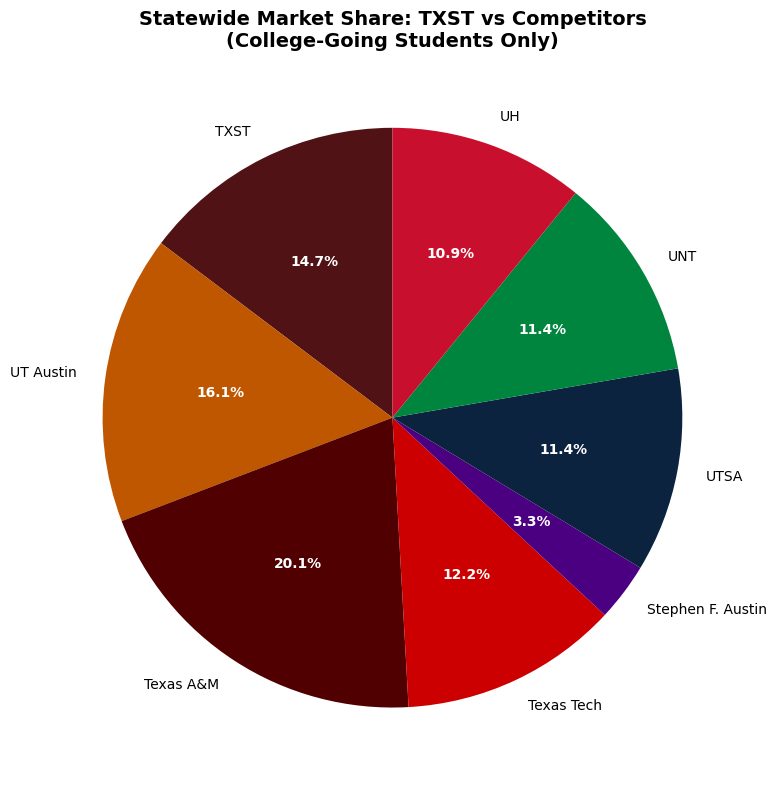

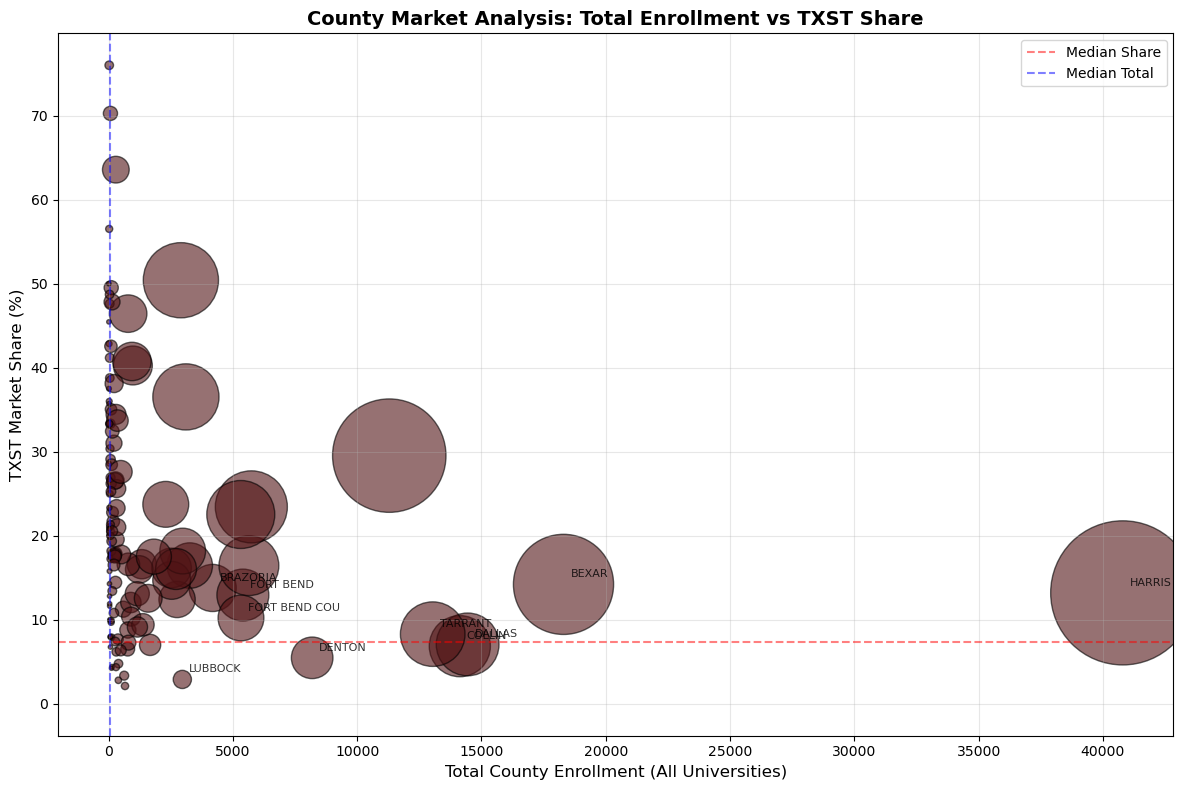


ANALYSIS COMPLETE!

Files created:
  - county_competitive_comparison.csv
  - recruitment_opportunities.csv
  - txst_market_share.png
  - competitive_enrollment.png
  - statewide_market_share.png
  - market_share_analysis.png


In [14]:
# =============================================================================
# VISUALIZATIONS
# =============================================================================

# 1. TXST Market Share by County
fig, ax = plt.subplots(figsize=(14, 8))
top_counties = market_share.head(30)
bars = ax.barh(range(len(top_counties)), top_counties['TXST_Market_Share'], color='#501214', alpha=0.7)
ax.set_yticks(range(len(top_counties)))
ax.set_yticklabels(top_counties['County'], fontsize=10)
ax.set_xlabel('TXST Market Share (%)', fontsize=12)
ax.set_title('Top 30 Counties by TXST Market Share\n(Among College-Going Students)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('txst_market_share.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Competitive Comparison (Top 20 counties)
if 'comparison_df' in locals():
    top_competitive = comparison_df.nlargest(20, 'Total')
    
    fig, ax = plt.subplots(figsize=(16, 10))
    x = np.arange(len(top_competitive))
    width = 0.1
    
    colors = {
        'TXST': '#501214',
        'UT Austin': '#BF5700',
        'Texas A&M': '#500000',
        'Texas Tech': '#CC0000',
        'Stephen F. Austin': '#4B0082',
        'UTSA': '#0C2340',
        'UNT': '#00853E',
        'UH': '#C8102E'
    }
    
    for i, school in enumerate(competitor_cols):
        offset = (i - len(competitor_cols)/2) * width
        ax.barh(x + offset, top_competitive[school], width, 
               label=school, color=colors[school], alpha=0.8)
    
    ax.set_yticks(x)
    ax.set_yticklabels(top_competitive['County'], fontsize=10)
    ax.set_xlabel('Number of Students Enrolled', fontsize=12)
    ax.set_title('Competitive Enrollment by County (Top 20)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig('competitive_enrollment.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. Market Share Pie Chart (Statewide)
if 'comparison_df' in locals():
    statewide_total = comparison_df[competitor_cols].sum()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    wedges, texts, autotexts = ax.pie(statewide_total, 
                                        labels=competitor_cols,
                                        autopct='%1.1f%%',
                                        colors=[colors[s] for s in competitor_cols],
                                        startangle=90)
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title('Statewide Market Share: TXST vs Competitors\n(College-Going Students Only)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('statewide_market_share.png', dpi=300, bbox_inches='tight')
    plt.show()

# 4. TXST Share vs Total Enrollment Scatter
if 'comparison_df' in locals():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Filter out counties with no enrollment
    plot_data = comparison_df[comparison_df['Total'] > 0].copy()
    
    scatter = ax.scatter(plot_data['Total'], 
                        plot_data['TXST_Share'],
                        s=plot_data['TXST']*2,
                        alpha=0.6, c='#501214', edgecolors='black')
    
    ax.set_xlabel('Total County Enrollment (All Universities)', fontsize=12)
    ax.set_ylabel('TXST Market Share (%)', fontsize=12)
    ax.set_title('County Market Analysis: Total Enrollment vs TXST Share', 
                fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add quadrant lines
    ax.axhline(y=plot_data['TXST_Share'].median(), color='red', linestyle='--', alpha=0.5, label='Median Share')
    ax.axvline(x=plot_data['Total'].median(), color='blue', linestyle='--', alpha=0.5, label='Median Total')
    
    # Label top opportunity counties
    if 'opportunities' in locals():
        for idx, row in opportunities.head(10).iterrows():
            ax.annotate(row['County'], 
                       (row['Total'], row['TXST_Share']),
                       fontsize=8, alpha=0.8, 
                       xytext=(5, 5), textcoords='offset points')
    
    ax.legend()
    plt.tight_layout()
    plt.savefig('market_share_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print("\nFiles created:")
print("  - county_competitive_comparison.csv")
print("  - recruitment_opportunities.csv")
print("  - txst_market_share.png")
print("  - competitive_enrollment.png")
print("  - statewide_market_share.png")
print("  - market_share_analysis.png")

In [15]:
import pandas as pd

# Load data
thecb_data = pd.read_csv('Datathon_Data/THECB_combined.csv')

# Get ALL unique institutions
all_institutions = thecb_data['Institution'].unique()

print(f"Total unique institutions: {len(all_institutions)}")
print("\n" + "="*70)
print("ALL INSTITUTIONS (copy this list):")
print("="*70)

# Print them all, numbered
for i, inst in enumerate(sorted(all_institutions), 1):
    print(f"{i:3d}. {inst}")

Total unique institutions: 325

ALL INSTITUTIONS (copy this list):
  1. ABILENE CHRISTIAN UNIVERSITY (003537) 
  2. ALAMO CCD NE LAKEVIEW COLLEGE (000309) 
  3. ALAMO CCD NW VISTA COLLEGE (000307) 
  4. ALAMO CCD PALO ALTO COLLEGE (023413) 
  5. ALAMO CCD SAN ANTONIO COLLEGE (009163) 
  6. ALAMO CCD ST. PHILIPS COLLEGE (003608) 
  7. ALVIN COMMUNITY COLLEGE (003539) 
  8. AMARILLO COLLEGE (003540) 
  9. ANGELINA COLLEGE (006661) 
 10. ANGELO STATE UNIVERSITY (003541) 
 11. AUSTIN COLLEGE (003543) 
 12. AUSTIN COMMUNITY COLLEGE (012015) 
 13. BAYLOR UNIVERSITY (003545) 
 14. BLINN COLLEGE DISTRICT (003549) 
 15. BRAZOSPORT COLLEGE (007857) 
 16. CENTRAL TEXAS COLLEGE (004003) 
 17. CISCO COLLEGE (003553) 
 18. CLARENDON COLLEGE (003554) 
 19. COASTAL BEND COLLEGE (003546) 
 20. COLLEGE OF THE MAINLAND COMMUN (007096) 
 21. COLLIN CO COMM COLL DISTRICT (023614) 
 22. CONCORDIA UNIVERSITY TEXAS (003557) 
 23. DALLAS BAPTIST UNIVERSITY (003560) 
 24. DALLAS COLLEGE BROOKHAVEN (021002) 
 25

In [21]:
# =============================================================================
# COMPLETE TEXAS COUNTY MAP - CORRECTED MARKET SHARE
# =============================================================================

import pandas as pd
import geopandas as gpd
import plotly.graph_objects as go
import json

# =============================================================================
# STEP 1: Load and clean THECB data
# =============================================================================

print("Loading THECB data...")
thecb_data = pd.read_csv('Datathon_data/THECB_combined.csv')

# Strip whitespace
thecb_data['Institution'] = thecb_data['Institution'].str.strip()

# Remove non-college categories
exclude_list = ['Not found', 'Not trackable', 'Total high school graduates']
print(f"Before removing non-college: {len(thecb_data)}")
thecb_data = thecb_data[~thecb_data['Institution'].isin(exclude_list)]
print(f"After removing non-college: {len(thecb_data)}")

# Standardize county names
thecb_data['County'] = thecb_data['County'].str.replace(' COUNTY', '', regex=False)
thecb_data['County'] = thecb_data['County'].str.replace(' COUNT', '', regex=False)
thecb_data['County'] = thecb_data['County'].str.replace(' COUN', '', regex=False)
thecb_data['County'] = thecb_data['County'].str.strip()

# =============================================================================
# STEP 2: Calculate TOTAL enrollment by county (ALL SCHOOLS)
# =============================================================================

total_by_county = thecb_data.groupby('County')['Students'].sum().reset_index()
total_by_county.columns = ['County', 'Total_All_Schools']

print(f"\n✅ Total enrollment for {len(total_by_county)} counties")
print(f"   Total students: {total_by_county['Total_All_Schools'].sum():,.0f}")

# =============================================================================
# STEP 3: Calculate enrollments by school
# =============================================================================

# TXST
txst_data = thecb_data[thecb_data['Institution'] == 'TEXAS STATE UNIVERSITY (003615)']
txst_by_county = txst_data.groupby('County')['Students'].sum().reset_index()
txst_by_county.columns = ['County', 'TXST']

# Competitors
schools = {
    'UT Austin': 'U. OF TEXAS AT AUSTIN (003658)',
    'Texas A&M': 'TEXAS A&M UNIVERSITY (003632)',
    'Texas Tech': 'TEXAS TECH UNIVERSITY (003644)',
    'Stephen F. Austin': 'STEPHEN F. AUSTIN STATE UNIV (003624)',
    'UTSA': 'U. OF TEXAS AT SAN ANTONIO (010115)',
    'UNT': 'UNIVERSITY OF NORTH TEXAS (003594)',
    'UH': 'UNIVERSITY OF HOUSTON (003652)'
}

school_dfs = {}
for name, institution in schools.items():
    df = thecb_data[thecb_data['Institution'] == institution]
    df_grouped = df.groupby('County')['Students'].sum().reset_index()
    df_grouped.columns = ['County', name]
    school_dfs[name] = df_grouped

# =============================================================================
# STEP 4: Merge everything
# =============================================================================

market_data = total_by_county.copy()
market_data = market_data.merge(txst_by_county, on='County', how='left')

for name, df in school_dfs.items():
    market_data = market_data.merge(df, on='County', how='left')

market_data = market_data.fillna(0)

# Calculate market share
market_data['TXST_Market_Share'] = (
    market_data['TXST'] / market_data['Total_All_Schools'] * 100
)

print("\n" + "="*70)
print("STATEWIDE MARKET SHARE")
print("="*70)
print(f"TXST: {market_data['TXST'].sum() / market_data['Total_All_Schools'].sum() * 100:.2f}%")
print(f"  ({market_data['TXST'].sum():,.0f} out of {market_data['Total_All_Schools'].sum():,.0f} students)")

# Save
market_data.to_csv('county_market_data_CORRECTED.csv', index=False)
print("\n✅ Saved: county_market_data_CORRECTED.csv")

# =============================================================================
# STEP 5: Create choropleth map
# =============================================================================

print("\nDownloading Texas county boundaries...")

try:
    counties = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip')
    texas_counties = counties[counties['STATEFP'] == '48'].copy()
    texas_counties['County'] = texas_counties['NAME'].str.upper()
    
    # Merge with market data
    texas_merged = texas_counties.merge(market_data, on='County', how='left')
    
    print(f"✅ Matched {texas_merged['TXST_Market_Share'].notna().sum()} counties")
    
    # Convert to GeoJSON
    texas_geojson = json.loads(texas_merged.to_json())
    
    # =============================================================================
    # Create interactive map
    # =============================================================================
    
    fig = go.Figure()
    
    # Choropleth layer
    fig.add_trace(go.Choropleth(
        geojson=texas_geojson,
        locations=texas_merged.index,
        z=texas_merged['TXST_Market_Share'],
        colorscale='RdYlGn',
        zmin=0,
        zmax=5,
        marker_line_color='black',
        marker_line_width=1.5,
        colorbar=dict(
            title='TXST<br>Market<br>Share<br>(%)',
            x=1.02,
            len=0.7,
            thickness=20
        ),
        hovertemplate=
            '<b>%{customdata[0]} County</b><br><br>' +
            '<b>TXST Students:</b> %{customdata[1]:,.0f}<br>' +
            '<b>TXST Market Share:</b> %{customdata[2]:.2f}%<br>' +
            '<b>Total Market (ALL colleges):</b> %{customdata[3]:,.0f}<br>' +
            '<br><b>Top Competitors:</b><br>' +
            '• UT Austin: %{customdata[4]:,.0f}<br>' +
            '• Texas A&M: %{customdata[5]:,.0f}<br>' +
            '• Texas Tech: %{customdata[6]:,.0f}<br>' +
            '• UNT: %{customdata[7]:,.0f}<br>' +
            '• UTSA: %{customdata[8]:,.0f}<br>' +
            '• UH: %{customdata[9]:,.0f}<br>' +
            '<extra></extra>',
        customdata=texas_merged[[
            'County', 'TXST', 'TXST_Market_Share', 'Total_All_Schools',
            'UT Austin', 'Texas A&M', 'Texas Tech', 'UNT', 'UTSA', 'UH'
        ]].fillna(0).values
    ))
    
    # TXST marker
    fig.add_trace(go.Scattergeo(
        lon=[-97.9],
        lat=[29.9],
        mode='markers+text',
        marker=dict(
            size=25,
            color='#501214',
            symbol='star',
            line=dict(width=3, color='gold')
        ),
        text=['TXST'],
        textfont=dict(size=14, color='#501214'),
        textposition='bottom center',
        hovertemplate='<b>Texas State University</b><br>San Marcos, TX<extra></extra>',
        showlegend=False
    ))
    
    # Configure map
    fig.update_geos(
        fitbounds="locations",
        visible=False
    )
    
    fig.update_layout(
        title=dict(
            text='<b>Texas State University: True Market Share Analysis</b><br>' +
                 '<sub>Market share vs. ALL Texas colleges | Hover for details | Zoom to explore</sub>',
            x=0.5,
            xanchor='center',
            font=dict(size=22)
        ),
        height=1000,
        width=1400,
        geo=dict(
            scope='usa',
            center=dict(lon=-99, lat=31),
            projection_scale=3.5
        )
    )
    
    # Save
    fig.write_html('texas_county_choropleth_FINAL.html')
    fig.write_image('texas_county_choropleth_FINAL.png', width=1920, height=1080, scale=2)
    
    print("\n✅ Maps saved!")
    print("   - texas_county_choropleth_FINAL.html (interactive - HOVER WORKS!)")
    print("   - texas_county_choropleth_FINAL.png (static for poster)")
    
    fig.show()
    
    print("\n" + "="*70)
    print("TOP 10 COUNTIES BY TXST MARKET SHARE")
    print("="*70)
    top_10 = market_data.nlargest(10, 'TXST_Market_Share')[
        ['County', 'TXST', 'Total_All_Schools', 'TXST_Market_Share']
    ]
    print(top_10.to_string(index=False))
    
except Exception as e:
    print(f"❌ Error creating map: {e}")
    import traceback
    traceback.print_exc()

Loading THECB data...
Before removing non-college: 50207
After removing non-college: 36175

✅ Total enrollment for 265 counties
   Total students: 951,423

STATEWIDE MARKET SHARE
TXST: 3.35%
  (31,856 out of 951,423 students)

✅ Saved: county_market_data_CORRECTED.csv

✅ Matched 233 counties

✅ Maps saved!
   - texas_county_choropleth_FINAL.html (interactive - HOVER WORKS!)
   - texas_county_choropleth_FINAL.png (static for poster)



TOP 10 COUNTIES BY TXST MARKET SHARE
       County   TXST  Total_All_Schools  TXST_Market_Share
     CALDWELL  185.0              773.0          23.932730
         HAYS 1466.0             6278.0          23.351386
        COMAL 1136.0             6862.0          16.554940
      BASTROP  365.0             2282.0          15.994741
GUADALUPE COU  383.0             2508.0          15.271132
    GUADALUPE  393.0             2604.0          15.092166
     GONZALES   66.0              502.0          13.147410
       BLANCO   52.0              410.0          12.682927
       TRAVIS 3335.0            26933.0          12.382579
   WILLIAMSON 1346.0            13449.0          10.008179


In [27]:
# =============================================================================
# TEXAS COUNTY MAP - GOLD TXST + BLACK/STRIPED FOR NO DATA
# =============================================================================

import pandas as pd
import geopandas as gpd
import plotly.graph_objects as go
import json
import numpy as np

# =============================================================================
# STEP 1: Load and clean THECB data
# =============================================================================

print("Loading THECB data...")
thecb_data = pd.read_csv('Datathon_data/THECB_combined.csv')

# Strip whitespace
thecb_data['Institution'] = thecb_data['Institution'].str.strip()

# Remove non-college categories
exclude_list = ['Not found', 'Not trackable', 'Total high school graduates']
print(f"Before removing non-college: {len(thecb_data)}")
thecb_data = thecb_data[~thecb_data['Institution'].isin(exclude_list)]
print(f"After removing non-college: {len(thecb_data)}")

# Standardize county names
thecb_data['County'] = thecb_data['County'].str.replace(' COUNTY', '', regex=False)
thecb_data['County'] = thecb_data['County'].str.replace(' COUNT', '', regex=False)
thecb_data['County'] = thecb_data['County'].str.replace(' COUN', '', regex=False)
thecb_data['County'] = thecb_data['County'].str.strip()

# =============================================================================
# STEP 2: Calculate enrollments
# =============================================================================

# Total ALL schools
total_by_county = thecb_data.groupby('County')['Students'].sum().reset_index()
total_by_county.columns = ['County', 'Total_All_Schools']

# TXST
txst_data = thecb_data[thecb_data['Institution'] == 'TEXAS STATE UNIVERSITY (003615)']
txst_by_county = txst_data.groupby('County')['Students'].sum().reset_index()
txst_by_county.columns = ['County', 'TXST']

# Competitors
schools = {
    'UT Austin': 'U. OF TEXAS AT AUSTIN (003658)',
    'Texas A&M': 'TEXAS A&M UNIVERSITY (003632)',
    'Texas Tech': 'TEXAS TECH UNIVERSITY (003644)',
    'Stephen F. Austin': 'STEPHEN F. AUSTIN STATE UNIV (003624)',
    'UTSA': 'U. OF TEXAS AT SAN ANTONIO (010115)',
    'UNT': 'UNIVERSITY OF NORTH TEXAS (003594)',
    'UH': 'UNIVERSITY OF HOUSTON (003652)'
}

school_dfs = {}
for name, institution in schools.items():
    df = thecb_data[thecb_data['Institution'] == institution]
    df_grouped = df.groupby('County')['Students'].sum().reset_index()
    df_grouped.columns = ['County', name]
    school_dfs[name] = df_grouped

# Merge
market_data = total_by_county.copy()
market_data = market_data.merge(txst_by_county, on='County', how='left')

for name, df in school_dfs.items():
    market_data = market_data.merge(df, on='County', how='left')

market_data = market_data.fillna(0)

# =============================================================================
# STEP 3: Determine dominant school (or NO DATA)
# =============================================================================

competitor_cols = ['TXST', 'UT Austin', 'Texas A&M', 'Texas Tech', 
                   'Stephen F. Austin', 'UTSA', 'UNT', 'UH']

# Check if ANY of the 8 schools have students
market_data['Has_Data'] = market_data[competitor_cols].sum(axis=1) > 0

# Set dominant school
market_data.loc[market_data['Has_Data'], 'Dominant_School'] = market_data.loc[market_data['Has_Data'], competitor_cols].idxmax(axis=1)
market_data.loc[~market_data['Has_Data'], 'Dominant_School'] = 'No Data'

market_data['Dominant_Enrollment'] = market_data[competitor_cols].max(axis=1)
market_data['Dominant_Share'] = (
    market_data['Dominant_Enrollment'] / market_data['Total_All_Schools'].replace(0, 1) * 100
)
market_data['TXST_Market_Share'] = (
    market_data['TXST'] / market_data['Total_All_Schools'].replace(0, 1) * 100
)

print(f"\n✅ Processed {len(market_data)} counties")

# Show dominance
print("\n" + "="*70)
print("COUNTY DOMINANCE BY SCHOOL")
print("="*70)
for school in competitor_cols + ['No Data']:
    count = (market_data['Dominant_School'] == school).sum()
    print(f"{school:20s}: {count:3d} counties")

market_data.to_csv('county_dominance_data.csv', index=False)

# =============================================================================
# STEP 4: Create map with GOLD TXST + BLACK for no data
# =============================================================================

print("\nDownloading Texas county boundaries...")

try:
    counties = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip')
    texas_counties = counties[counties['STATEFP'] == '48'].copy()
    texas_counties['County'] = texas_counties['NAME'].str.upper()
    
    texas_merged = texas_counties.merge(market_data, on='County', how='left')
    texas_merged['Dominant_School'] = texas_merged['Dominant_School'].fillna('No Data')
    
    print(f"✅ Matched {texas_merged['Dominant_School'].notna().sum()} counties")
    
    # =============================================================================
    # School colors - TXST IS GOLD, No Data is BLACK
    # =============================================================================
    
    school_colors = {
        'TXST': '#FFD700',              # 🏆 GOLD
        'UT Austin': '#BF5700',         # Burnt Orange
        'Texas A&M': '#500000',         # Aggie Maroon
        'Texas Tech': '#CC0000',        # Tech Red
        'Stephen F. Austin': '#4B0082', # Purple
        'UTSA': '#0C2340',              # Navy Blue
        'UNT': '#00853E',               # Green
        'UH': '#C8102E',                # Crimson Red
        'No Data': '#2F2F2F'            # ⚫ DARK GRAY/BLACK
    }
    
    texas_merged['Color'] = texas_merged['Dominant_School'].map(school_colors)
    
    # Numeric mapping (including No Data)
    all_schools = competitor_cols + ['No Data']
    school_to_num = {school: i for i, school in enumerate(all_schools)}
    texas_merged['School_Num'] = texas_merged['Dominant_School'].map(school_to_num)
    
    # Colorscale
    colorscale = []
    n_schools = len(all_schools)
    for i, school in enumerate(all_schools):
        colorscale.append([i/n_schools, school_colors[school]])
        colorscale.append([(i+1)/n_schools, school_colors[school]])
    
    texas_geojson = json.loads(texas_merged.to_json())
    
    # =============================================================================
    # Create map
    # =============================================================================
    
    fig = go.Figure()
    
    # Choropleth
    fig.add_trace(go.Choropleth(
        geojson=texas_geojson,
        locations=texas_merged.index,
        z=texas_merged['School_Num'],
        colorscale=colorscale,
        showscale=False,
        marker_line_color='white',
        marker_line_width=1.5,
        hovertemplate=
            '<b>%{customdata[0]} County</b><br><br>' +
            '<b>🏆 Dominant School:</b> %{customdata[1]}<br>' +
            '<b>Their Enrollment:</b> %{customdata[2]:,.0f}<br>' +
            '<b>Their Market Share:</b> %{customdata[3]:.1f}%<br>' +
            '<br><b>TXST:</b> %{customdata[4]:,.0f} (%{customdata[5]:.1f}%)<br>' +
            '<b>Total Market:</b> %{customdata[6]:,.0f}<br>' +
            '<br><b>All Enrollments:</b><br>' +
            '• UT Austin: %{customdata[7]:,.0f}<br>' +
            '• Texas A&M: %{customdata[8]:,.0f}<br>' +
            '• Texas Tech: %{customdata[9]:,.0f}<br>' +
            '• UNT: %{customdata[10]:,.0f}<br>' +
            '• UTSA: %{customdata[11]:,.0f}<br>' +
            '• UH: %{customdata[12]:,.0f}<br>' +
            '• Stephen F. Austin: %{customdata[13]:,.0f}<br>' +
            '<extra></extra>',
        customdata=texas_merged[[
            'County', 'Dominant_School', 'Dominant_Enrollment', 'Dominant_Share',
            'TXST', 'TXST_Market_Share', 'Total_All_Schools',
            'UT Austin', 'Texas A&M', 'Texas Tech', 'UNT', 'UTSA', 'UH', 'Stephen F. Austin'
        ]].fillna(0).values
    ))
    
    # TXST marker
    fig.add_trace(go.Scattergeo(
        lon=[-97.9],
        lat=[29.9],
        mode='markers+text',
        marker=dict(size=30, color='#501214', symbol='star',
                   line=dict(width=4, color='#FFD700')),
        text=['TXST'],
        textfont=dict(size=16, color='#501214'),
        textposition='bottom center',
        hovertemplate='<b>Texas State University</b><br>San Marcos, TX<extra></extra>',
        showlegend=False
    ))
    
    fig.update_geos(fitbounds="locations", visible=False)
    
    fig.update_layout(
        title=dict(
            text='<b>Texas County Dominance by University</b><br>' +
                 '<sub>🏆 GOLD = TXST Territory | ⚫ BLACK = No data from these 8 schools | Hover for details</sub>',
            x=0.5,
            xanchor='center',
            font=dict(size=22)
        ),
        height=1000,
        width=1600,
        geo=dict(scope='usa', center=dict(lon=-99, lat=31), projection_scale=3.5),
        paper_bgcolor='#1a1a1a'
    )
    
    # Custom legend
    legend_traces = []
    for school in all_schools:
        legend_traces.append(
            go.Scattergeo(
                lon=[None],
                lat=[None],
                mode='markers',
                marker=dict(size=15, color=school_colors[school], 
                           line=dict(width=1, color='white')),
                name=f"{'🏆 ' if school == 'TXST' else '⚫ ' if school == 'No Data' else ''}{school}",
                showlegend=True
            )
        )
    
    for trace in legend_traces:
        fig.add_trace(trace)
    
    fig.update_layout(
        legend=dict(
            x=0.02,
            y=0.98,
            bgcolor='rgba(255,255,255,0.95)',
            bordercolor='black',
            borderwidth=2,
            font=dict(size=13)
        )
    )
    
    # Save
    fig.write_html('texas_county_GOLD_TXST_BLACK_NODATA.html')
    fig.write_image('texas_county_GOLD_TXST_BLACK_NODATA.png', width=1920, height=1080, scale=2)
    
    print("\n✅ Maps saved!")
    print("   - texas_county_GOLD_TXST_BLACK_NODATA.html (interactive)")
    print("   - texas_county_GOLD_TXST_BLACK_NODATA.png (static)")
    
    fig.show()
    
    print("\n" + "="*70)
    print("🏆 TXST'S GOLD COUNTIES")
    print("="*70)
    txst_counties = market_data[market_data['Dominant_School'] == 'TXST'].sort_values('TXST', ascending=False)
    print(txst_counties[['County', 'TXST', 'Total_All_Schools', 'TXST_Market_Share']].head(20).to_string(index=False))
    
    print("\n" + "="*70)
    print("⚫ NO DATA COUNTIES (None of the 8 schools present)")
    print("="*70)
    no_data_counties = market_data[market_data['Dominant_School'] == 'No Data']
    print(f"Total: {len(no_data_counties)} counties")
    print(no_data_counties[['County', 'Total_All_Schools']].head(20).to_string(index=False))
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Loading THECB data...
Before removing non-college: 50207
After removing non-college: 36175

✅ Processed 265 counties

COUNTY DOMINANCE BY SCHOOL
TXST                :  25 counties
UT Austin           :   0 counties
Texas A&M           :  62 counties
Texas Tech          :  75 counties
Stephen F. Austin   :  18 counties
UTSA                :  24 counties
UNT                 :  12 counties
UH                  :   5 counties
No Data             :  44 counties

✅ Matched 254 counties

✅ Maps saved!
   - texas_county_GOLD_TXST_BLACK_NODATA.html (interactive)
   - texas_county_GOLD_TXST_BLACK_NODATA.png (static)



🏆 TXST'S GOLD COUNTIES
       County   TXST  Total_All_Schools  TXST_Market_Share
       TRAVIS 3335.0            26933.0          12.382579
         HAYS 1466.0             6278.0          23.351386
        COMAL 1136.0             6862.0          16.554940
         BELL  546.0            10585.0           5.158243
    GUADALUPE  393.0             2604.0          15.092166
GUADALUPE COU  383.0             2508.0          15.271132
      BASTROP  365.0             2282.0          15.994741
     CALDWELL  185.0              773.0          23.932730
     VICTORIA  120.0             1969.0           6.094464
      CORYELL  103.0             1530.0           6.732026
 SAN PATRICIO   85.0             2372.0           3.583474
         KERR   84.0             1054.0           7.969639
     GONZALES   66.0              502.0          13.147410
       DEWITT   52.0              701.0           7.417974
       BLANCO   52.0              410.0          12.682927
     LAMPASAS   48.0            

In [29]:
# =============================================================================
# TXST OPPORTUNITY MAP - GOLD = WHERE TO RECRUIT!
# =============================================================================

import pandas as pd
import geopandas as gpd
import plotly.graph_objects as go
import json
import numpy as np

# Load data
print("Loading data...")
market_data = pd.read_csv('county_dominance_data.csv')

# =============================================================================
# Calculate OPPORTUNITY SCORE (Better Algorithm)
# =============================================================================

print("\nCalculating opportunity scores...")

# OPPORTUNITY = High total students + Low TXST presence + Reasonable competition

# Filter out tiny markets
market_data['Is_Viable_Market'] = market_data['Total_All_Schools'] > 500

# Normalize scores
market_data['Market_Size_Score'] = np.log1p(market_data['Total_All_Schools']) / np.log1p(market_data['Total_All_Schools'].max()) * 100

# Growth potential (inverse of current TXST share)
market_data['Growth_Potential'] = (100 - market_data['TXST_Market_Share'].clip(0, 100))

# Competition factor (how hard to break in)
# Lower is better - we want markets where dominant school doesn't have 100% control
market_data['Breakable_Market'] = 100 - market_data['Dominant_Share'].clip(0, 100)

# COMPOSITE SCORE
# 50% market size, 30% growth potential, 20% breakable market
market_data['Opportunity_Score'] = (
    market_data['Market_Size_Score'] * 0.50 +
    market_data['Growth_Potential'] * 0.30 +
    market_data['Breakable_Market'] * 0.20
)

# Zero out non-viable markets
market_data.loc[~market_data['Is_Viable_Market'], 'Opportunity_Score'] = 0

# Zero out TXST strongholds (we already have them)
market_data.loc[market_data['Dominant_School'] == 'TXST', 'Opportunity_Score'] = 0

# Classify
def classify_opportunity(row):
    if row['Dominant_School'] == 'TXST':
        return '⭐ TXST Territory'
    elif not row['Is_Viable_Market']:
        return '⚫ Small Market'
    elif row['Opportunity_Score'] > 75:
        return '🔥 TOP PRIORITY'
    elif row['Opportunity_Score'] > 60:
        return '🎯 HIGH OPPORTUNITY'
    elif row['Opportunity_Score'] > 45:
        return '📊 MEDIUM POTENTIAL'
    else:
        return '💤 LOW PRIORITY'

market_data['Opportunity_Category'] = market_data.apply(classify_opportunity, axis=1)

print("\n" + "="*70)
print("OPPORTUNITY BREAKDOWN")
print("="*70)
print(market_data['Opportunity_Category'].value_counts().sort_index())

market_data.to_csv('county_opportunity_analysis_v2.csv', index=False)

# =============================================================================
# Create Map with BETTER COLORS
# =============================================================================

print("\nCreating map...")

try:
    counties = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip')
    texas_counties = counties[counties['STATEFP'] == '48'].copy()
    texas_counties['County'] = texas_counties['NAME'].str.upper()
    
    texas_merged = texas_counties.merge(market_data, on='County', how='left')
    texas_merged['Opportunity_Score'] = texas_merged['Opportunity_Score'].fillna(0)
    
    print(f"✅ Matched {len(texas_merged)} counties")
    
    texas_geojson = json.loads(texas_merged.to_json())
    
    fig = go.Figure()
    
    # Choropleth with INVERSE colors (HIGH = BRIGHT, LOW = DARK)
    fig.add_trace(go.Choropleth(
        geojson=texas_geojson,
        locations=texas_merged.index,
        z=texas_merged['Opportunity_Score'],
        colorscale=[
            [0.0, '#2F4F4F'],    # Dark gray (low/TXST territory)
            [0.3, '#8B4513'],    # Brown (low-medium)
            [0.5, '#FF8C00'],    # Dark orange (medium)
            [0.7, '#FFD700'],    # GOLD (high)
            [1.0, '#FF4500']     # Red-orange (TOP PRIORITY)
        ],
        reversescale=False,
        marker_line_color='white',
        marker_line_width=1.2,
        colorbar=dict(
            title='Recruitment<br>Opportunity',
            x=1.02,
            len=0.7,
            thickness=20,
            tickvals=[0, 25, 50, 75, 100],
            ticktext=['Low/<br>Established', 'Low', 'Medium', 'High', 'TOP<br>Priority']
        ),
        hovertemplate=
            '<b>%{customdata[0]} County</b><br><br>' +
            '<b>🎯 OPPORTUNITY: %{customdata[1]}/100</b><br>' +
            '<b>Priority:</b> %{customdata[2]}<br>' +
            '<br><b>Market Analysis:</b><br>' +
            '• Total Students: %{customdata[3]:,.0f}<br>' +
            '• TXST Currently: %{customdata[4]:,.0f} (%{customdata[5]:.1f}%)<br>' +
            '• Dominant School: %{customdata[6]} (%{customdata[7]:.1f}%)<br>' +
            '<br><b>Growth Potential: %{customdata[8]:.0f}/100</b><br>' +
            '<br><b>Competition:</b><br>' +
            '• UT Austin: %{customdata[9]:,.0f}<br>' +
            '• Texas A&M: %{customdata[10]:,.0f}<br>' +
            '• Texas Tech: %{customdata[11]:,.0f}<br>' +
            '• UNT: %{customdata[12]:,.0f}<br>' +
            '<extra></extra>',
        customdata=texas_merged[[
            'County', 'Opportunity_Score', 'Opportunity_Category',
            'Total_All_Schools', 'TXST', 'TXST_Market_Share',
            'Dominant_School', 'Dominant_Share', 'Growth_Potential',
            'UT Austin', 'Texas A&M', 'Texas Tech', 'UNT'
        ]].fillna(0).values
    ))
    
    # TXST marker
    fig.add_trace(go.Scattergeo(
        lon=[-97.9],
        lat=[29.9],
        mode='markers+text',
        marker=dict(size=35, color='#501214', symbol='star',
                   line=dict(width=4, color='white')),
        text=['TXST'],
        textfont=dict(size=16, color='white'),
        textposition='bottom center',
        hovertemplate='<b>Texas State University</b><br>San Marcos<extra></extra>',
        showlegend=False
    ))
    
    # Label TOP opportunities
    top_opps = texas_merged[texas_merged['Opportunity_Score'] > 70].nlargest(10, 'Opportunity_Score')
    
    for idx, row in top_opps.iterrows():
        centroid = row['geometry'].centroid
        fig.add_trace(go.Scattergeo(
            lon=[centroid.x],
            lat=[centroid.y],
            mode='markers+text',
            marker=dict(size=12, color='red', symbol='circle',
                       line=dict(width=2, color='white')),
            text=[row['County']],
            textfont=dict(size=10, color='black', family='Arial Black'),
            textposition='top center',
            hoverinfo='skip',
            showlegend=False
        ))
    
    fig.update_geos(fitbounds="locations", visible=False)
    
    fig.update_layout(
        title=dict(
            text='<b>TXST Strategic Recruitment Map: Where to Focus Resources</b><br>' +
                 '<sub>🔥 BRIGHT COLORS = High Opportunity | DARK = Low Priority or Already Established</sub>',
            x=0.5,
            xanchor='center',
            font=dict(size=22)
        ),
        height=1000,
        width=1600,
        geo=dict(scope='usa', center=dict(lon=-99, lat=31), projection_scale=3.5)
    )
    
    fig.write_html('txst_recruitment_priorities.html')
    fig.write_image('txst_recruitment_priorities.png', width=1920, height=1080, scale=2)
    
    print("\n✅ Priority map saved!")
    print("   - txst_recruitment_priorities.html")
    print("   - txst_recruitment_priorities.png")
    
    fig.show()
    
    # =============================================================================
    # TOP TARGETS
    # =============================================================================
    
    print("\n" + "="*70)
    print("🔥 TOP 15 RECRUITMENT TARGETS")
    print("="*70)
    
    top_targets = market_data[
        (market_data['Dominant_School'] != 'TXST') &
        (market_data['Opportunity_Score'] > 0)
    ].nlargest(15, 'Opportunity_Score')
    
    print(f"\n{'Rank':<5} {'County':<15} {'Score':<8} {'Total':<10} {'TXST':<8} {'Dominant':<20}")
    print("-" * 80)
    
    for rank, (idx, row) in enumerate(top_targets.iterrows(), 1):
        print(f"{rank:<5} {row['County']:<15} {row['Opportunity_Score']:>5.0f}/100  "
              f"{row['Total_All_Schools']:>8,.0f}  {row['TXST']:>6,.0f}  "
              f"{row['Dominant_School']:<20}")
    
    total_opportunity = top_targets['Total_All_Schools'].sum() - top_targets['TXST'].sum()
    
    print("\n" + "="*70)
    print(f"📊 TOTAL GROWTH POTENTIAL IN TOP 15: {total_opportunity:,.0f} students")
    print(f"💰 If TXST captured just 10% more: {total_opportunity * 0.10:,.0f} new students")
    print("="*70)
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Loading data...

Calculating opportunity scores...

OPPORTUNITY BREAKDOWN
Opportunity_Category
⚫ Small Market        127
⭐ TXST Territory       25
🎯 HIGH OPPORTUNITY     14
🔥 TOP PRIORITY         99
Name: count, dtype: int64

Creating map...
✅ Matched 254 counties

✅ Priority map saved!
   - txst_recruitment_priorities.html
   - txst_recruitment_priorities.png



🔥 TOP 15 RECRUITMENT TARGETS

Rank  County          Score    Total      TXST     Dominant            
--------------------------------------------------------------------------------
1     HARRIS             97/100   145,843   5,386  UH                  
2     DALLAS             95/100    77,758   1,021  UNT                 
3     HIDALGO            94/100    46,824     928  Texas A&M           
4     EL PASO            94/100    38,033     342  Texas Tech          
5     TARRANT            94/100    55,816   1,081  UNT                 
6     COLLIN             93/100    44,777     969  UNT                 
7     BEXAR              93/100    66,194   2,601  UTSA                
8     CAMERON            90/100    21,725     537  UTSA                
9     WEBB               89/100    14,937     200  UTSA                
10    DENTON             89/100    23,678     448  UNT                 
11    MCLENNAN           88/100    10,456     151  Texas A&M           
12    BRAZORIA          

In [32]:
market_data = pd.read_csv('county_dominance_data.csv')
total = market_data['Total_All_Schools'].sum()
print(f"Total: {total:,.0f}")

Total: 951,423
